In [1]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from tensorflow.random import set_seed
from tensorflow.math import confusion_matrix

from sklearn.metrics import classification_report
import numpy as np
from glob import glob
import seaborn as sns
import math
import matplotlib.pyplot as plt

np.random.seed(42)
set_seed(42)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from PIL import ImageFilter

from tensorflow import keras
model = keras.models.load_model('../../models/covid/covid_vgg1.h5')

In [4]:
height, width = 224, 224
batch_size=64


def generate_data(DIR):
    datagen = ImageDataGenerator(rescale=1./255.)
    
    generator = datagen.flow_from_directory(
        DIR,
        batch_size=batch_size,
        shuffle=True,
        seed=42,
        class_mode='categorical',
        target_size=(height, width),
        classes=None
    )
    return generator

TRAINING_DIR = '../../Covid19-dataset/train'
TESTING_DIR = '../../Covid19-dataset/test'

train_generator = generate_data(TRAINING_DIR)
test_generator = generate_data(TESTING_DIR)

total_image = np.concatenate([train_generator.labels,test_generator.labels])

print('\n\n',{'Normal_cases':len(np.where(total_image==0)[0]),
      'Viral_Pneumonia_cases':len(np.where(total_image==1)[0]),
             'Covid_cases':len(np.where(total_image==2)[0])})

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


 {'Normal_cases': 137, 'Viral_Pneumonia_cases': 90, 'Covid_cases': 90}


In [5]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

2/2 [==============================] - 5s 382ms/step - loss: 0.0871 - accuracy: 0.9697
Test Loss: 0.08714903891086578, Test Accuracy: 0.9696969985961914


2/2 [==============================] - 1s 8ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       0.91      1.00      0.95        20
           2       1.00      0.90      0.95        20

    accuracy                           0.97        64
   macro avg       0.97      0.97      0.97        64
weighted avg       0.97      0.97      0.97        64



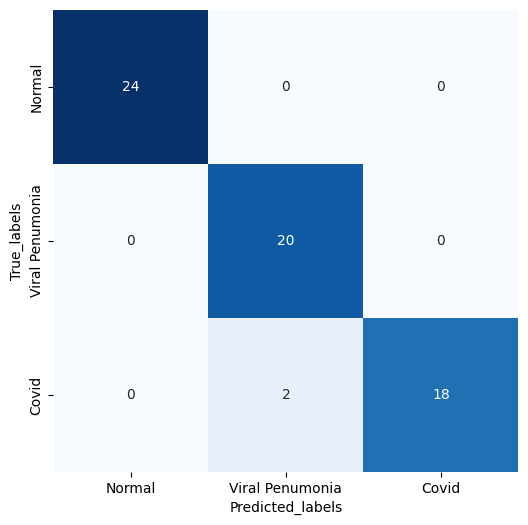

In [6]:
xtest = test_generator[0][0]
ytest = test_generator[0][1]
ytest = np.where(ytest==1)[1]

ypred = model.predict(xtest)
ypred = np.argmax(ypred,axis=1)

plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(ytest,ypred), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Viral Penumonia','Covid'],yticklabels=['Normal','Viral Penumonia','Covid'])  
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
print(classification_report(ytest,ypred))

1/1 [==============================] - 0s 133ms/step


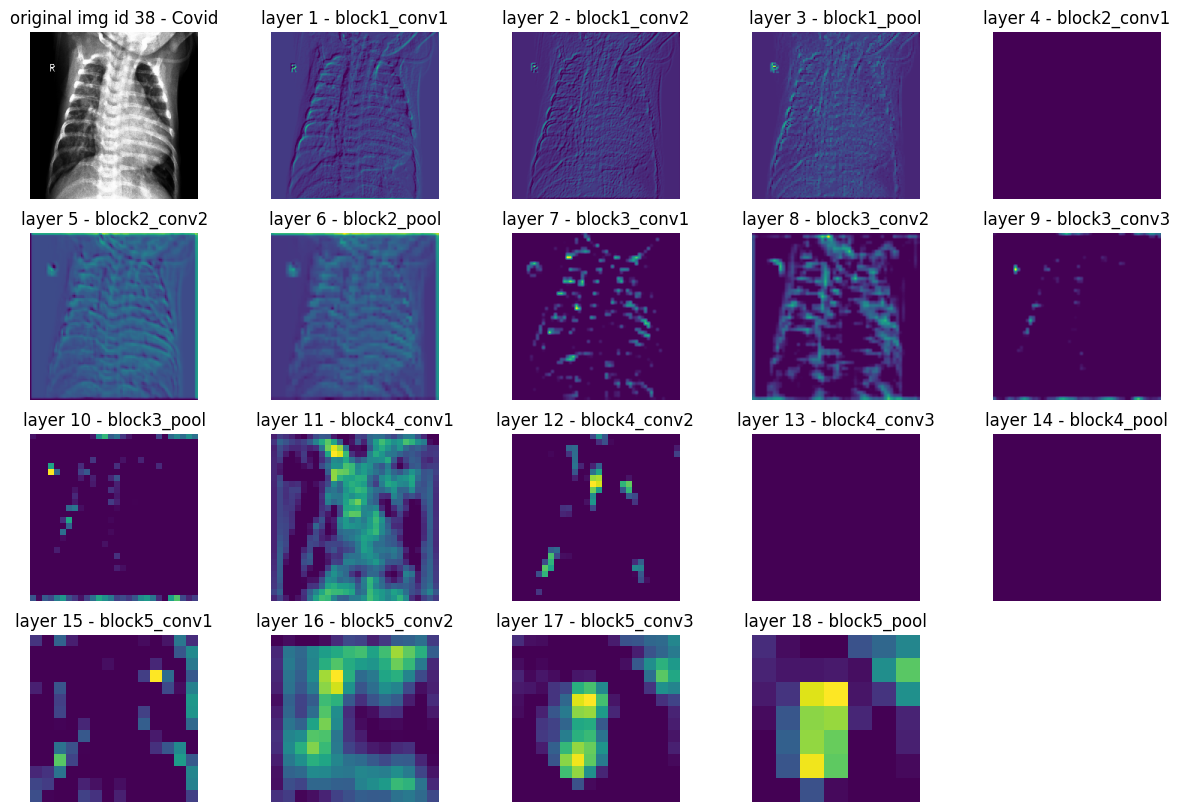

In [30]:
from random import randint
from tensorflow.keras.models import Sequential, Model
import matplotlib.pylab as plt 
import numpy as np

def get_feature_maps(model, layer_id, input_image):
    model_ = Model(inputs=[model.input], 
                   outputs=[model.layers[layer_id].output])
    return model_.predict(np.expand_dims(input_image, 
                                         axis=0)).transpose()

def plot_features_map(img_idx=None, layer_idx=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18], 
                      x_test=xtest, ytest=ytest, cnn=model):
    if img_idx == None:
        img_idx = randint(0, ytest.shape[0])
    input_image = x_test[img_idx]
    fig, ax = plt.subplots(4,5,figsize=(15,10))
    for i in ax:
        for j in i:
            j.axis('off')
    ax[0][0].imshow(input_image)
    ax[0][0].set_title('original img id {} - {}'.format(img_idx, 
                                                        labels[int(ytest[img_idx])]))
    for i, l in enumerate(layer_idx):
        feature_map = get_feature_maps(cnn, l, input_image)
        ax[(i+1)//5][(i+1)%5].imshow(feature_map[0].transpose()[0])
        ax[(i+1)//5][(i+1)%5].set_title('layer {} - {}'.format(l, 
                                                              cnn.layers[l].get_config()['name']))
            
    return img_idx

labels = ['Normal','Viral Penumonia','Covid']
fmap = 0
img_idx = plot_features_map()
plt.savefig('Feature_maps.png')